# Running a two-phase simulation with GROMACS

This Tutorial will give you examples on how you can run a full gromacs simulation with a two-phase box. This includes a setup with coffe module gmx_mkbox_twophase and the following simulation.



In [1]:
%reload_ext autoreload

In [2]:
%autoreload 2

## Creating a two-phase box using gmx_mkbox using one substance

First we start off creating a homogeneous box with a vapor and liquid phase. We will use the Ethane Molecule c2.pdb and the same forcefield as in the previous examples (charmm36-andi).
To create a twophase box we have to import the python module.

In [1]:
from coffe.gmx import boxes

The input and output is similar two the gmx_mkbox_homogeneous function as it returns a structure and a topology file. However because you have a vapor and a liquid phase, two n_mols are required as input.

The function places three boxes with each one having the box size (nm) given in  the input. The middle box is the liquid phase containing n_mols_l molecules surrounded by two boxes with a vapor phase each containing n_mols_v molecules.

As further required input you need the input structure (pdb-file) and a force-field.

When you want to setup a twophase system you need to fill your boxes accordingly to the expected densities near to the boiling curve. In our case we will later on apply a temperature of184 K and a pressure of 1.013 bar. You can get experimental densities from the internet, e.g. at https://webbook.nist.gov/chemistry/fluid/ .

With the densities given you can either choose n_mol_l or box_size freely and calculate the other. With 512 molecules in the liquid phase, you get a box_size of 3.95 nm and a n_mol_v of 5.

The boxes are created via:

In [2]:
structure, topology = boxes.gmx_mkbox(boxtype = "twophase",
                                      substance = "../c2.pdb",
                                      n_mols_v = 10,
                                      n_mols_l = 512,
                                      box_size = 3.95,
                                      ff_dir="../charmm36-andi/charmm36-andi.ff",
                                      work_dir="./output_I",
                                      substance_name="Ethane")

The forcefield can be specified using ```gmx_ff``` (for built-in Gromacs force fields) or ```ff_dir``` (for custom force fields, as in our case). 

The argument ```work_dir``` specifies the working directory for coffe.

Now lets have a look at the output the function provided:

In [ ]:
%%bash
ls -lrta output_I/

The code created
- an input topology *Ethane.itp* that defines the Ethane force field,
- a topology file *topol.top* that includes the itp file and the force field,
- a structure file *out.gro* that defines the simulation box.

Now that we set up the box we can start the energy minimization.

## Energy Minimization

Now, we can create an instance of GmxCalculation for the energy minimization, using the *em_cg.mpd* file that is also in the directory.

In [3]:
from coffe.gmx.sim import GmxCalculation
import os

emin = GmxCalculation(structure, topology, "../../em_cg.mdp",
                     work_dir="./output_I/emin")
emin()

A look at the log file shows that the calculation has finished.

In [4]:
%%bash
tail ./output_I/emin/.coffe/log.txt

2019-05-16 15:16:53,089 - DEBUG - CoffeWorkDir: /home/frott3s/coffe/examples/04_full_simulation_twophase_box_test/output_I/emin
2019-05-16 15:16:53,089 - DEBUG - ... running GmxCalculation
2019-05-16 15:16:53,089 - DEBUG - ... with variables {'checkpoint': None, 'overwrite': False, 'mdp_options': {}, 'work_dir': './output_I/emin', 'mdp_file': '../../em_cg.mdp', 'topology': '/home/frott3s/coffe/examples/04_full_simulation_twophase_box_test/output_I/topol.top', 'structure': '/home/frott3s/coffe/examples/04_full_simulation_twophase_box_test/output_I/out.gro', 'self': <coffe.gmx.sim.GmxCalculation object at 0x7f22b0c24978>, '__class__': <class 'coffe.gmx.sim.GmxCalculation'>}
2019-05-16 15:16:53,107 - INFO - Gromacs Version: 2016.3
2019-05-16 15:16:53,108 - INFO - Starting Gromacs preprocessor.
2019-05-16 15:16:57,920 - INFO - Running calculation
2019-05-16 15:17:04,665 - INFO - Gmx calculation finished.


Using the *observables* module we can now read and plot the potential energy.

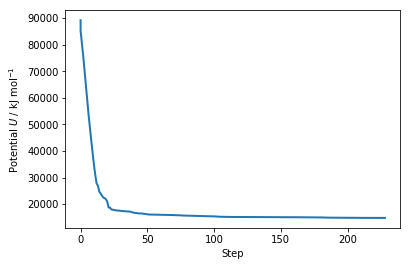

In [5]:
from coffe.gmx import observables
pot = observables.gmx_calc_energy(emin.work_dir, ["Potential"])

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel("Step")
ax.set_ylabel(r"Potential $U$ / kJ $\mathrm{mol}^{-1}$")
ax.plot(pot[:,0], pot[:,1], lw=2)

## NVT and NPT equilibration

After the Energy Minimization step we can now use the output we got from it and perform a NVT simulation and couple our structure with a warm bath with a temperature of 184.4 K.

In [6]:
mdp_file = "../../nvt.mdp"
structure = "../emin/confout.gro"
nvt = GmxCalculation(structure, topology, mdp_file,
                     work_dir="./output_I/nvt")
nvt()

KeyboardInterrupt: 

... and calculate the potential energy and temperature.

In [ ]:
pot_t = observables.gmx_calc_energy(nvt.work_dir, ["Potential", "Temperature"])


And plot our results:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel("Time / ps")
ax.set_ylabel(r"Potential $U$ / kJ $\mathrm{mol}^{-1}$")
ax.plot(pot_t[:,0], pot_t[:,1], lw=2)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel("Time / ps")
ax.set_ylabel(r"Temperature $T$ / K")
ax.plot(pot_t[:,0], pot_t[:,2], lw=2)

After the NVT equilibration we run the NPT equilibration step, where we apply 1 atm = 1.013 bar of pressure to our system.

In [7]:
mdp_file = "../../npt.mdp"
structure = "../nvt/confout.gro"

npt = GmxCalculation(structure, topology, mdp_file,
                     work_dir = "./output_I/npt",
                     checkpoint = "../nvt/state.cpt")
npt()


Traceback (most recent call last):
  File "/home/frott3s/coffe/coffe/core/coffedir.py", line 172, in wrapper
    return func(*args, **kwargs)
  File "/home/frott3s/coffe/coffe/gmx/sim.py", line 142, in __call__
    assert self._ready_for_grompp()
AssertionError


AssertionError: 

In [ ]:
vol_p = observables.gmx_calc_energy(npt.work_dir, ["Volume", "Pressure"])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel("Time / ps")
ax.set_ylabel(r"Volume $U$ / kJ $\mathrm{mol}^{-1}$")
ax.plot(vol_p[:,0], vol_p[:,2], lw=2)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel("Time / ps")
ax.set_ylabel(r"Pressure $U$ / kJ $\mathrm{mol}^{-1}$")
ax.plot(vol_p[:,0],vol_p[:,1], lw=2)

## Production step

After the system is equilibrated, we can start the production step:

In [ ]:
mdp_file = "../../prod.mdp"
structure = "../npt/confout.gro"

prod = GmxCalculation(structure, topology, mdp_file,
                     work_dir = "./output_I/prod",
                     checkpoint = "../npt/state.cpt")
prod()

In [ ]:
vol_p = observables.gmx_calc_energy(npt.work_dir, ["Volume", "Pressure"])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel("Time / ps")
ax.set_ylabel(r"Volume $U$ / kJ $\mathrm{mol}^{-1}$")
ax.plot(vol_p[:,0], vol_p[:,2], lw=2)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel("Time / ps")
ax.set_ylabel(r"Pressure $U$ / kJ $\mathrm{mol}^{-1}$")
ax.plot(vol_p[:,0],vol_p[:,1], lw=2)

## Using coffe command chain generators

The whole simulation can also be run with the coffe command chain generators. This is useful when you want to run one or more simulations as a whole. As shown in example 3 you start by using the GmxChainGenerator command:

In [ ]:
from coffe.gmx import sim, simgen
generator = simgen.GmxChainGenerator(
    names=["emin", "nvt", "npt", "prod"], 
    mdp_files=["em_cg.mdp", "nvt.mdp", "npt.mdp", "prod.mdp"],
    mdp_options=None # can be used to overwrite options in the mdp files
)

In [ ]:
%%bash 
pwd

Now that we got the generator, we can create our boxes and use the generator to generate simulation chains for out system.

In [ ]:
from coffe.gmx import boxes
structure, topology = boxes.gmx_mkbox(cfg_file="boxes.cfg", section="ethane")

ethane_chain = generator.generate("output_chain",structure,topology)

You can execute the chain and run the simulation locally by calling:

In [ ]:
ethane_chain()

## Running the chain on a cluster

After the chain is generated we can use the coffe cluster module to create a job for our simulation on the cluster. A cluster job is created as follows: 

In [ ]:
from coffe.core import cluster

queueing=None
batch_template=None
job_name="coffe_job"
work_dir="./output_cluster"
job = cluster.ClusterJob(queueing, batch_template, job_name, work_dir)

On an actual compute cluster, you will need to set queueing to "torque" or "slurm", depending on which submission system your cluster uses. Moreover, you need to provide a batch template file, i.e. a file that contains only the preamble of a batch script. (By setting both options to ```None```, the job will still run locally.) The commands will be inserted automatically by adding simulation classes to the cluster job:

In [ ]:
job += ethane_chain

Each simulation instance that is added to a cluster must have an empty ```__call__``` function.
It is also possible to append strings, which will be interpreted as shell commands.
This can be helpful, e.g., to run analyses after the actual simulation.

In [ ]:
# something trivial
job += 'echo "Hallo" '

To start a job, just call:

In [ ]:
# job_id = job.submit()    

```job.submit()``` returns a job id, to track your job.

Moreover, it provides functionality to check the status of a job or kill a job.
```
job.get_status() 
job.kill()
```

job.get_status() returns one of the following strings:

|result | meaning |
|--|---|
|not written | batch script is not written, yet |
|not submitted | job is not submitted, yet|
|queueing | job is in queue |
|running | job is running |
|completed | job is completed  |
|error | job failed|

An easier way to start a cluster job by executing the python scipt workflow.py in the directory workflow:

In [2]:
%%bash
pwd
cd workflow/
#python workflow.py
cd ..

/home/frott3s/coffe/examples/04_full_simulation_twophase_box


## Putting It All Together
In the above code, the actual submission was commented out, to prevent this notebook from starting expensive calculations.
To test the whole workflow on a real cluster, checkout the subdirectory "workflow". This subdirectory contains an executable python script "workflow.py" and a configuration file "workflow.cfg" to run the discussed simulations on a real cluster.

Note that you may need to adapt the batch script and queueing system to your cluster configuration.

## Setting up boxes with n substances and different input options
The coffe functions gmx_mkbox_homogeneous and gmx_mkbox_twophase can also be used to insert n different substances into the generated simulation box. You can do this by passing the different substances in a list. When using multiple substances, you need to make sure to pass a list of ```n_mol``` and ```substance_name``` with the same length as ```substance```. In the following example we will fill a homogeneous and two-phase box with Ethane and Octane:

In [1]:
from coffe.gmx import boxes

substances = ["../c2.pdb", "../c8.pdb"]
substance_names = ["Ethane", "Octane"]
n_mols = [50, 20]
n_mols_v = [5, 2]
n_mols_l = [50,20]

In [3]:
structure_homogeneous, topology_homogeneous = boxes.gmx_mkbox(boxtype = "homogeneous",
                                                        substance = substances,
                                                        substance_name = substance_names,
                                                        n_mols = n_mols,
                                                        box_size = 5,
                                                        ff_dir = "../charmm36-andi/charmm36-andi.ff",
                                                        work_dir = "./output_homogeneous_I")

NameError: name 'gmx_mkbox' is not defined

In [ ]:
structure_twophase, topology_twophase = boxes.gmx_mkbox(boxtype = "twophase",
                                                  substance = substances,
                                                  substance_name = substance_names,
                                                  n_mols_v = n_mols_v,
                                                  n_mols_l = n_mols_l,
                                                  box_size = 5,
                                                  ff_dir = "../charmm36-andi/charmm36-andi.ff",
                                                  work_dir = "./output_twophase_I")

Depending on the application it can be useful to use different inputs than ```n_mols``` and ```box_size```. As an alternative you can use the target density (in kg/m³) as input. The 3 input options are listed below:

1. ```n_mols``` and ```box_size``` 
2. ```density``` (or ```density_v```, ```density_l```), ```m_mol``` and ```box_size```
3. ```density```, ```m_mol``` and ```n_mols```    (only with ```gmx_mkbox_homogeneous```)


When using the target density as input it is necessary to specify the molecular mass (```m_mol``` in g/mol) for each substance. You can choose to either fix the box size (2.) or the number of molecules (3.) when setting up the box. Option 3 is only possible with ```gmx_mkbox_homogeneous```. ```density_l``` is the target density in the liquid phase and ```density_v``` in the vapor phase.

In [6]:
from coffe.gmx import boxes

substances = ["../c2.pdb", "../c8.pdb"]
substance_names = ["Ethane", "Octane"]
m_mols = [30.07, 114.22]
density =  400
densities_v = [20, 10]
densities_l = [400, 300]
n_mols = [50,20]

In [7]:
# Option 2 with gmx_mkbox_twophase
structure_twophase2, topology_twophase2 = boxes.gmx_mkbox(boxtype = "twophase",
                                                   substance = substances,
                                                   substance_name = substance_names,
                                                   density_v = densities_v,
                                                   density_l = densities_l,
                                                   m_mol = m_mols,
                                                   box_size = 5,
                                                   ff_dir = "../charmm36-andi/charmm36-andi.ff",
                                                   work_dir = "./output_twophase_II")

In [ ]:
# Option 3 with gmx_mkbox_homogeneous
structure_homogeneous, topology_homogeneous = boxes.gmx_mkbox(boxtype = "homogeneous",
                                                       substance = substances,
                                                       substance_name = substance_names,
                                                       density = density,
                                                       m_mol =  m_mols, 
                                                       n_mols = n_mols,
                                                       ff_dir = "../charmm36-andi/charmm36-andi.ff",
                                                       work_dir = "./output_homogeneous_II")

## Analyzing densities of two-phase structures with get_densities
To analyze the density profile of a two-phase system you can use the coffe function ```get_densities```. As input you need the structure file or trajectory (.xtc, .trr or .gro) of the system you want to analyze and the binary run input file (.tpr) you get from the pre processor grompp. You also need to specify how many different substances are in the system. Just like in the gromacs you can choose the first and last frame you want to observe:


- Input:
    - traj: trajectory/structure file (.tpr/.trr/.gro)
    - topol: binary run file (.tpr)
    - n-substances: number of substances in the system
    - first_frame (0): First Frame to be read
    - last_frame (0): last frame to be read
    - dens ("mass"): density type, can either be "mass", "number" or "charge"
    - show_plot (True): show the plot of the fitted function. 
    - out ("density.xvg"): name of the xvg output
    - work_dir ("."): name of the working directory

- Output:
    - rho_l: density of the liquid/solid phase
    - rho_v: density of the vapor phase
    - D: width of the interfaces (nm)
    - z_l: position of the left interface (nm)
    - z_r: position of the right interface (nm)
    - df: Pandas DataFrame with information of the densities of each substance
    - popt_l: fitting parameters for the left side
    - popt_r: fitting parameters for the right side
    
In the following step we will da an energy minimization on the system twophase_II and use get_densities to read out the densities

In [ ]:
from coffe.gmx.sim import GmxCalculation
import os

emin = GmxCalculation(structure_twophase2, topology_twophase2, "../em_cg.mdp",
                     work_dir="./output_twophase_II")
emin()

In [ ]:
from coffe.gmx import observables
from coffe.core import pkgdata
%matplotlib inline

traj = "traj.trr"
topol = "topol.tpr"

rho_l, rho_v, i_w, z_l, z_r, df, left_fit, right_fit = observables.get_densities(
            traj, topol, n_substances=2, first_frame=0, last_frame=-1,
            dens="mass", show_plot=True, work_dir="./output_twophase_II/")

print(rho_l, rho_v, i_w, z_l, z_r)
print(df)